In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
from os import listdir
from scipy.stats import ks_2samp, f_oneway
import scipy.cluster.hierarchy as sch
from matplotlib.ticker import FormatStrFormatter
from scipy.spatial.distance import squareform

rcParams = {'font.size': 20, 
            'font.weight': 'normal', 
            'font.family': 'sans-serif',
            'axes.unicode_minus':False, 
            'axes.labelweight':'normal', 
            'xtick.labelsize' : 16,
            'ytick.labelsize' : 16,
            'axes.labelsize': 16,
            'axes.spines.right' : False,
            'axes.spines.top' : False}

plt.rcParams.update(rcParams)

whiskerprops = dict(color='black',linewidth=1.5)
capprops = dict(color='black', linewidth=0.5)
medianprops = dict(linewidth=1.5, linestyle='-', color='black')

In [2]:
genomes = ['OSA','OSB','Synechococcus','Chloroflexus_MS_G', 'Chloracidobacterium_thermophilum_B',
           'Roseiflexus','Aerophilum']
data_dir = '/Users/harihara/Mount/Hotsprings_Variant_Structure_Data_Analysis/'
Summary = {}
for g in genomes:
    Summary[g] = {}
    for f in ['Orphaned_Reads.Summary.pkl','Reassembly.Summary.pkl',
              'Respresentative_Abundances.Summary.pkl', 'SAG.Summary.pkl']:
        try:
            d = pkl.load(open(data_dir+g+'/Summary/'+f, 'rb'))
            Summary[g][f] = d
        except FileNotFoundError:
            print(g, f)
        

OSA Respresentative_Abundances.Summary.pkl
OSA SAG.Summary.pkl
OSB Respresentative_Abundances.Summary.pkl
OSB SAG.Summary.pkl
Synechococcus Orphaned_Reads.Summary.pkl
Synechococcus Reassembly.Summary.pkl
Chloroflexus_MS_G SAG.Summary.pkl
Chloracidobacterium_thermophilum_B SAG.Summary.pkl
Roseiflexus SAG.Summary.pkl
Aerophilum SAG.Summary.pkl


In [3]:
df_Metadata = pd.read_csv('/Users/harihara/Research-Activities/Data/Hot-Spring/hotspring_metadata.csv', sep = ",")
df_Metadata = df_Metadata.sort_values(by = ['Spring_Name','SampleID'])
samples = [s for s in df_Metadata['SampleID'].tolist()]
ms, os = (df_Metadata['Spring_Name'] == 'Mushroom').sum(),(df_Metadata['Spring_Name'] == 'Octopus').sum()

sample_spring = dict(zip(df_Metadata.index.tolist(), df_Metadata.Spring_Name.tolist()))
x_ticks = []
for s in samples:
    x_ticks.append(s.replace("Hotspr20Sample","").replace("Hotspr2Sample","").replace("HotsprSample","")\
                   .replace("HotsprSampl","").replace("HotsprSamp","").replace("Hotspr",""))
mscolor, oscolor = 'red', 'blue'
spring_colors = [mscolor]*ms+[oscolor]*os
sample_spring = dict(zip(df_Metadata.SampleID.tolist(), df_Metadata.Spring_Name.tolist()))

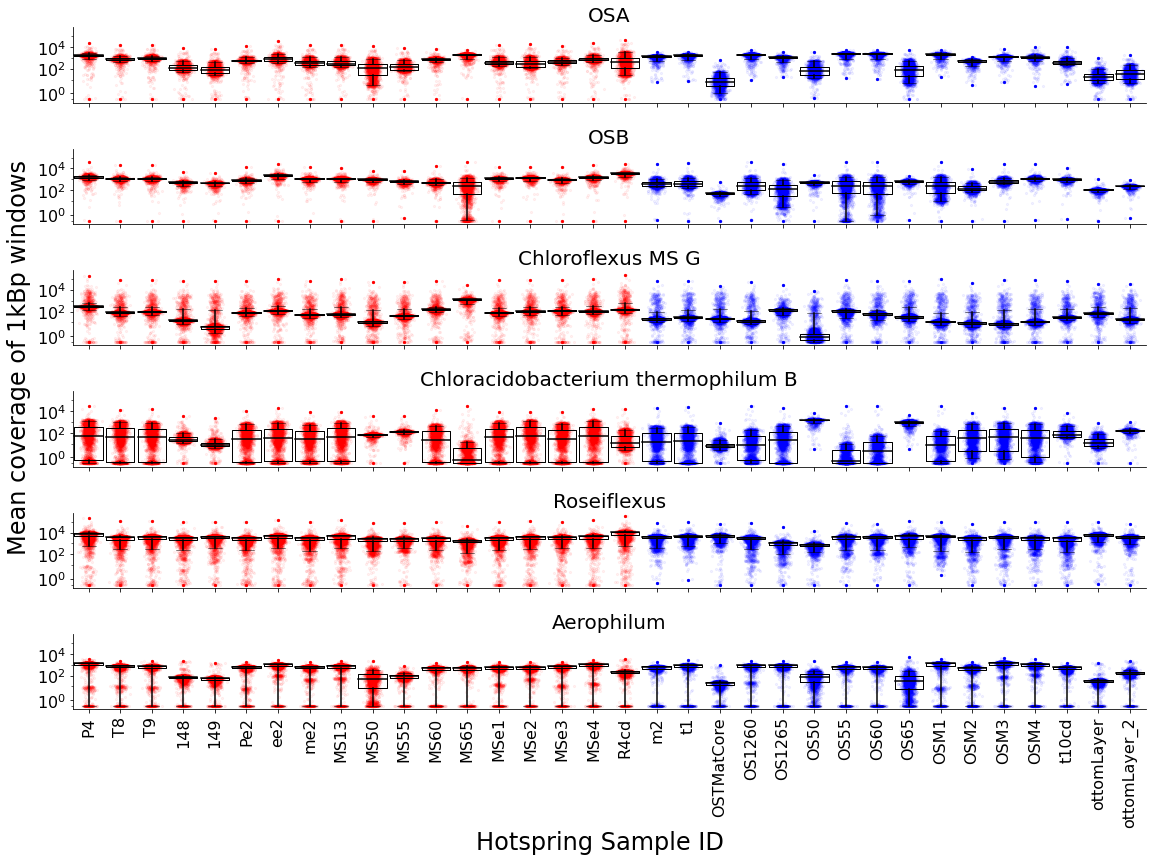

In [6]:
plt.rcParams.update(rcParams)
flierprops = dict(marker='x', markersize=0.5, linestyle='none')
boxprops = dict(linestyle='-', linewidth=1.0, color='black')

fig, ax = plt.subplots(6,1, figsize=(16,12), sharex = True, sharey = True)
i = 0
for g in genomes:
    if g == 'Synechococcus':
        continue
    
    boxes = list(Summary[g]["Reassembly.Summary.pkl"]['df_cov'][samples].T.values)
    positions = list(range(0, 34))
    for j in range(0, len(positions)):
        y = boxes[j]
        ax[i].boxplot(y, positions = [positions[j]], whis = [5,95], widths = [0.9], showfliers = False, 
                      boxprops = boxprops, flierprops = flierprops, whiskerprops = whiskerprops, 
                      capprops = capprops, medianprops = medianprops)
        x = np.random.normal(positions[j], 0.095, size=len(y))
        ax[i].scatter(x,y,color = spring_colors[j],alpha = 0.05, marker = 'o', s = 5)
        ax[i].scatter([positions[j]]*2, [max(y), min(y)], color = spring_colors[j], marker = 'o', s = 5)
    ax[i].set_title(g.replace("_"," "), size = 20)
    i+=1
ax[5].set_yscale('symlog')
ax[5].set_yticks([1,100,10000])
ax[5].set_xticks(range(0, 34))
ax[5].set_xticklabels(x_ticks, rotation = 90)
fig.text(0.4, 0, 'Hotspring Sample ID', size = 24)
fig.text(-0.007, 0.57, 'Mean coverage of 1kBp windows', va='center', rotation='vertical', size = 24)
fig.tight_layout()

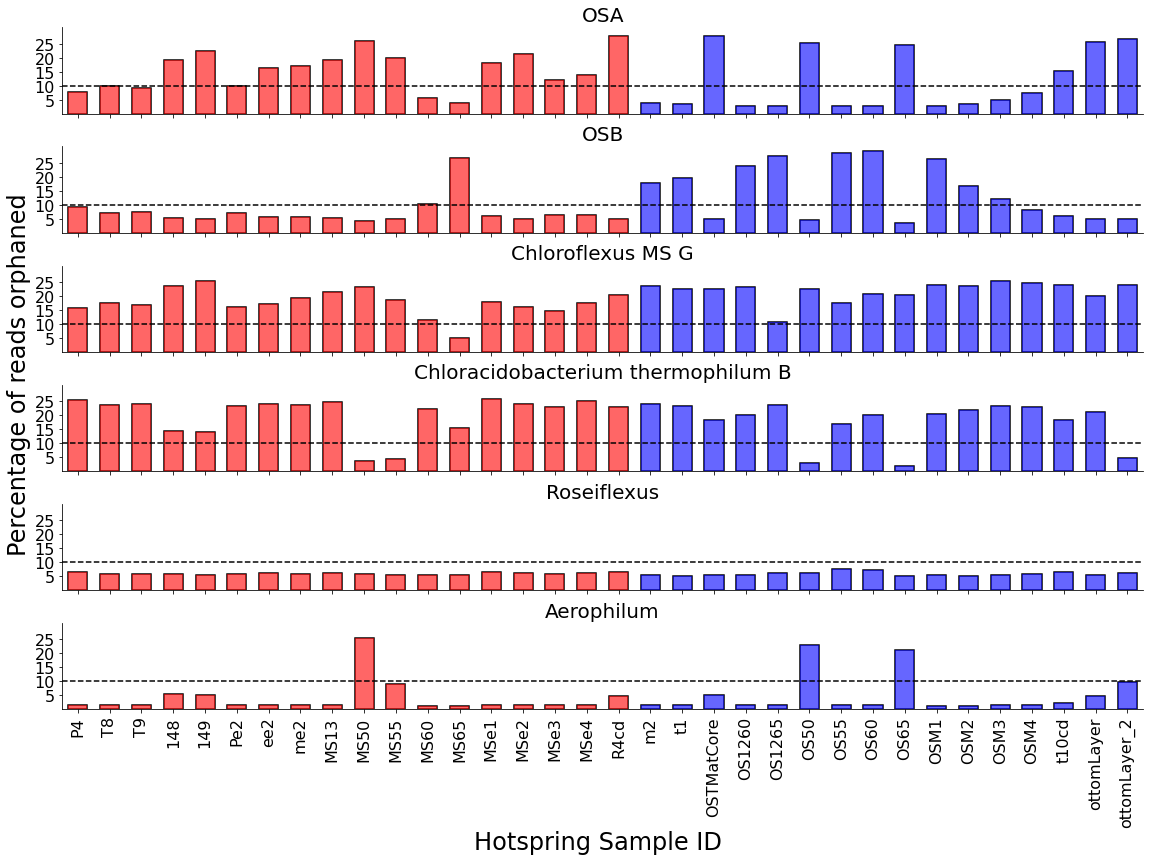

In [7]:
plt.rcParams.update(rcParams)

fig, ax = plt.subplots(6,1, figsize =(16,12), sharex = True, sharey = True)
i = 0
for g in genomes: 
    if g == 'Synechococcus':
        continue
    df = Summary[g]['Reassembly.Summary.pkl']['Summary']
    df = df.set_index('Sample')
    df = df.loc[samples]
    df['Frac_Orphaned'] = df['Orphaned Reads in Only One Genome ']/df['ReadCounts']*100.0
    bars = ax[i].bar(range(0,34), df['Frac_Orphaned'], width = 0.6, color = 'black',fill=False, linewidth = 1.5)
    bars = ax[i].bar(range(0,34), df['Frac_Orphaned'], width = 0.6, color = spring_colors, alpha = 0.6)
    ax[i].set_title(g.replace("_"," "), size = 20)
    ax[i].axhline(10, linestyle = '--', color = 'black')
    i += 1
ax[5].set_yticks([5,10,15,20,25])
ax[5].set_xlim([-0.5,33.5])
ax[5].set_xticks(range(0, 34))
ax[5].set_xticklabels(x_ticks, rotation = 90)

fig.text(0.4, 0, 'Hotspring Sample ID', size = 24)
fig.text(-0.005, 0.55, 'Percentage of reads orphaned', va='center', rotation='vertical', size = 24)

fig.tight_layout()
fig.subplots_adjust(hspace = 0.375)

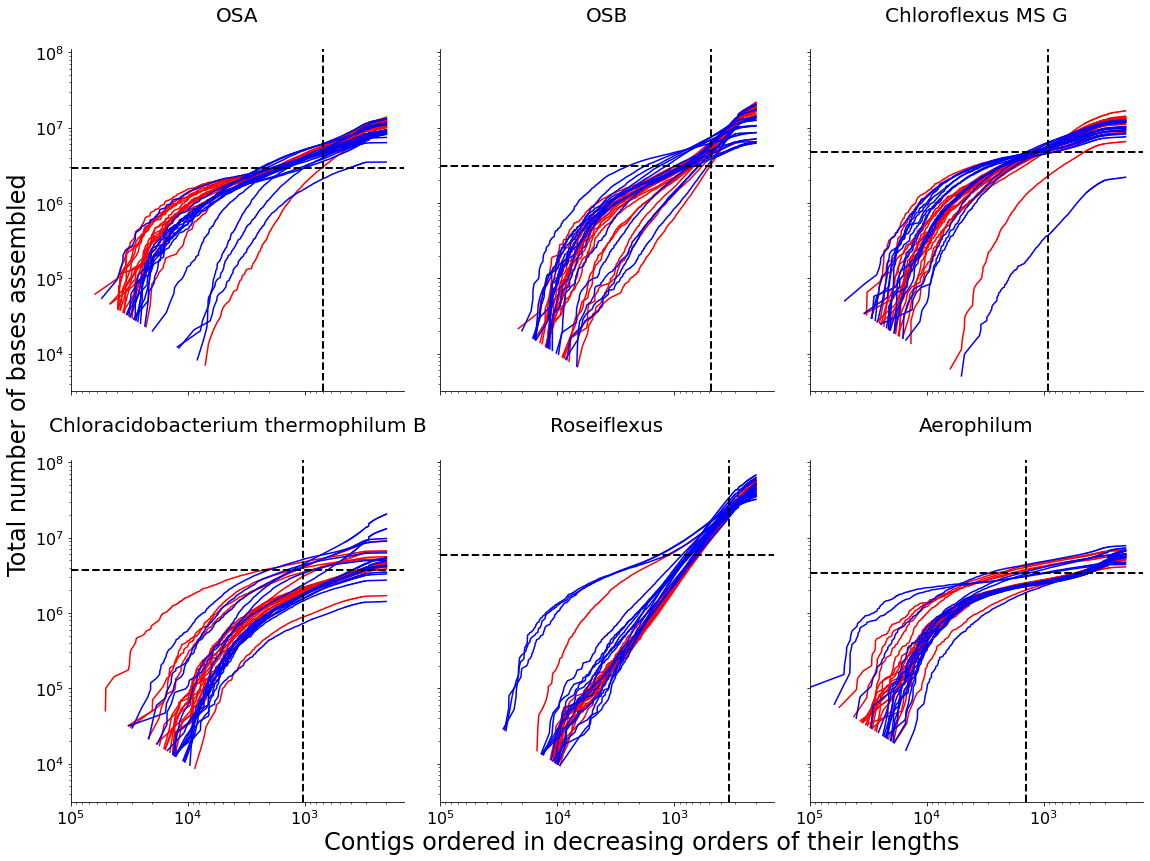

In [9]:
sample_dict = dict(zip(df_Metadata['SampleID'].tolist(), df_Metadata['Spring_Name'].tolist()))
fig, ax = plt.subplots(2, 3, figsize = (16, 12), sharex = True, sharey = True)
k = 0
for g in genomes:
    if g == 'Synechococcus': continue
    i, j = int(k/3), int(k%3)
    avg_n50 = 0.0
    for p in range(0, len(samples)):
        ax[i][j].plot(Summary[g]['Reassembly.Summary.pkl']['Assembly'][samples[p]]['lengths'], 
                      Summary[g]['Reassembly.Summary.pkl']['Assembly'][samples[p]]['cumulative'], 
                      color = spring_colors[p])
        avg_n50 += Summary[g]['Reassembly.Summary.pkl']['Assembly'][samples[p]]['NGx']
    ax[i][j].axhline(Summary[g]['Reassembly.Summary.pkl']['Assembly'][samples[p]]['Glen'], color = 'black', 
                     linestyle = '--', linewidth = 2)
    ax[i][j].axvline(avg_n50/len(samples), color = 'black', linestyle = '--', linewidth = 2)
    ax[i][j].set_title(g.replace("_"," ")+"\n", size = 20)
    
    k += 1
ax[0][0].set_xlim(ax[0][0].get_xlim()[::-1])
ax[0][0].set_yscale('log')
ax[0][0].set_xscale('log')
ax[0][0].set_xlim([100000, 141])
fig.text(0.27, 0, 'Contigs ordered in decreasing orders of their lengths', size = 24)
fig.text(-0.005, 0.55, 'Total number of bases assembled', va='center', rotation='vertical', size = 24)

fig.tight_layout()

Text(0.5, 0, 'Putative Variant Groups')

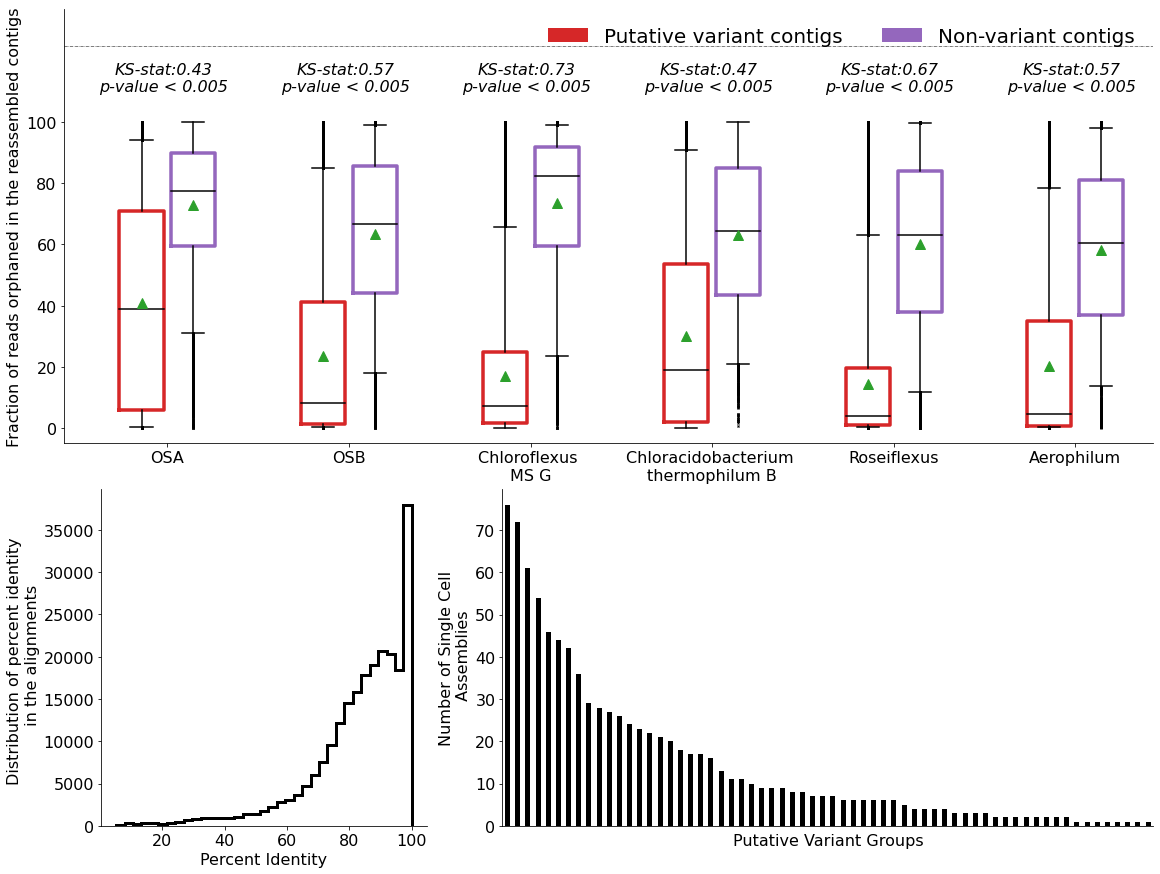

In [20]:
flierprops = dict(marker='x', markersize=2, linestyle='none', color = 'gray')
whiskerprops = dict(color='black',linewidth=1.5)
capprops = dict(color='black', linewidth=1.5)
medianprops = dict(linewidth=1.5, linestyle='-', color='black')
meanprops = dict(markersize = 10, color = 'black')

plt.rcParams.update(rcParams)

fig = plt.figure(constrained_layout = True,figsize = (16,12))
gs0 = fig.add_gridspec(2, 1,  height_ratios=[1.25,1])
gs1 = gs0[0].subgridspec(1, 1)
ax1 = fig.add_subplot(gs1[0])

gs2 = gs0[1].subgridspec(1, 2, width_ratios = [1,2])
ax2, ax3 = fig.add_subplot(gs2[0]), fig.add_subplot(gs2[1])

gaps = 3.5
counter = 0

xticklabels = ["OSA","OSB","Chloroflexus \nMS G","Chloracidobacterium \nthermophilum B","Roseiflexus", 
               "Aerophilum"]
xticks = []
for g in genomes:
    if g == 'Synechococcus': continue
    df = Summary[g]['Orphaned_Reads.Summary.pkl']
    stat, p_val = ks_2samp(df.loc[df['Novel'] == -1]['Or_Ratio'], df.loc[df['Novel'] == 1]['Or_Ratio'])
    positions =  [counter, counter + 1]
    boxes = [df.loc[df['Novel'] == -1]['Or_Ratio'], df.loc[df['Novel'] == 1]['Or_Ratio']]
    c = ['C3', 'C4']
    
    for i in range(0, len(positions)):
        ax1.boxplot([boxes[i]], positions=[positions[i]], whis = [5,95], widths = [0.85],
                     showfliers = True, boxprops = dict(linestyle='-', linewidth=3.5, color=c[i]),
                     flierprops = flierprops, whiskerprops = whiskerprops, capprops = capprops, 
                     medianprops = medianprops, showmeans = True, meanprops = meanprops)
    
    if p_val <= 0.005: ptext = r'p-value < 0.005'
    else: ptext = r'p-value > 0.005'
    ax1.text(counter+0.85/2, 110, r'KS-stat:'+str(round(stat, 2))+'\n'+ptext, ha = 'center', 
             size = 16, fontstyle = 'italic')
    xticks.append(counter+0.5)
    counter += gaps
    
ax1.bar(-10,0,color = 'C3', label = 'Putative variant contigs')
ax1.bar(-10,0,color = 'C4', label = 'Non-variant contigs')
ax1.legend(ncol = 2, loc = 1, frameon = False)    
ax1.set_xticks(xticks)    
ax1.set_xticklabels(xticklabels, rotation = 0)    
ax1.set_ylim([-5, 137.0])
ax1.axhline(125, color = 'black', linewidth = 0.5, linestyle = '-.')
ax1.set_yticks(range(0, 110, 20))
ax1.set_ylabel('Fraction of reads orphaned in the reassembled contigs')
ax1.set_xlim([-1.5, counter-1.5])

Summary['Synechococcus']['SAG.Summary.pkl']['Filtered_Alignments'][['PIdent']].plot(kind = 'hist', bins = 35, 
                                                                                    ax = ax2, histtype='step',
                                                                                    linewidth=3, 
                                                                                    legend = False, 
                                                                                    color = 'black')
ax2.set_xlabel('Percent Identity')
ax2.set_ylabel('Distribution of percent identity \n in the alignments')

Summary['Synechococcus']['SAG.Summary.pkl']['Group_Counts'].plot(kind = 'bar', ax = ax3, legend = False,
                                                                 color = 'black')
ax3.set_ylabel('Number of Single Cell\n Assemblies')
ax3.set_xticks([])
ax3.set_xlabel('Putative Variant Groups')

#fig.tight_layout()
#fig.savefig('/Users/harihara/Research-Activities/Plots/Hot_Spring_Plots/Synechococcus-Paper/Orphaned_Reads.pdf')

Text(0, 0.5, 'Bray-Curtis Dissimilarity')

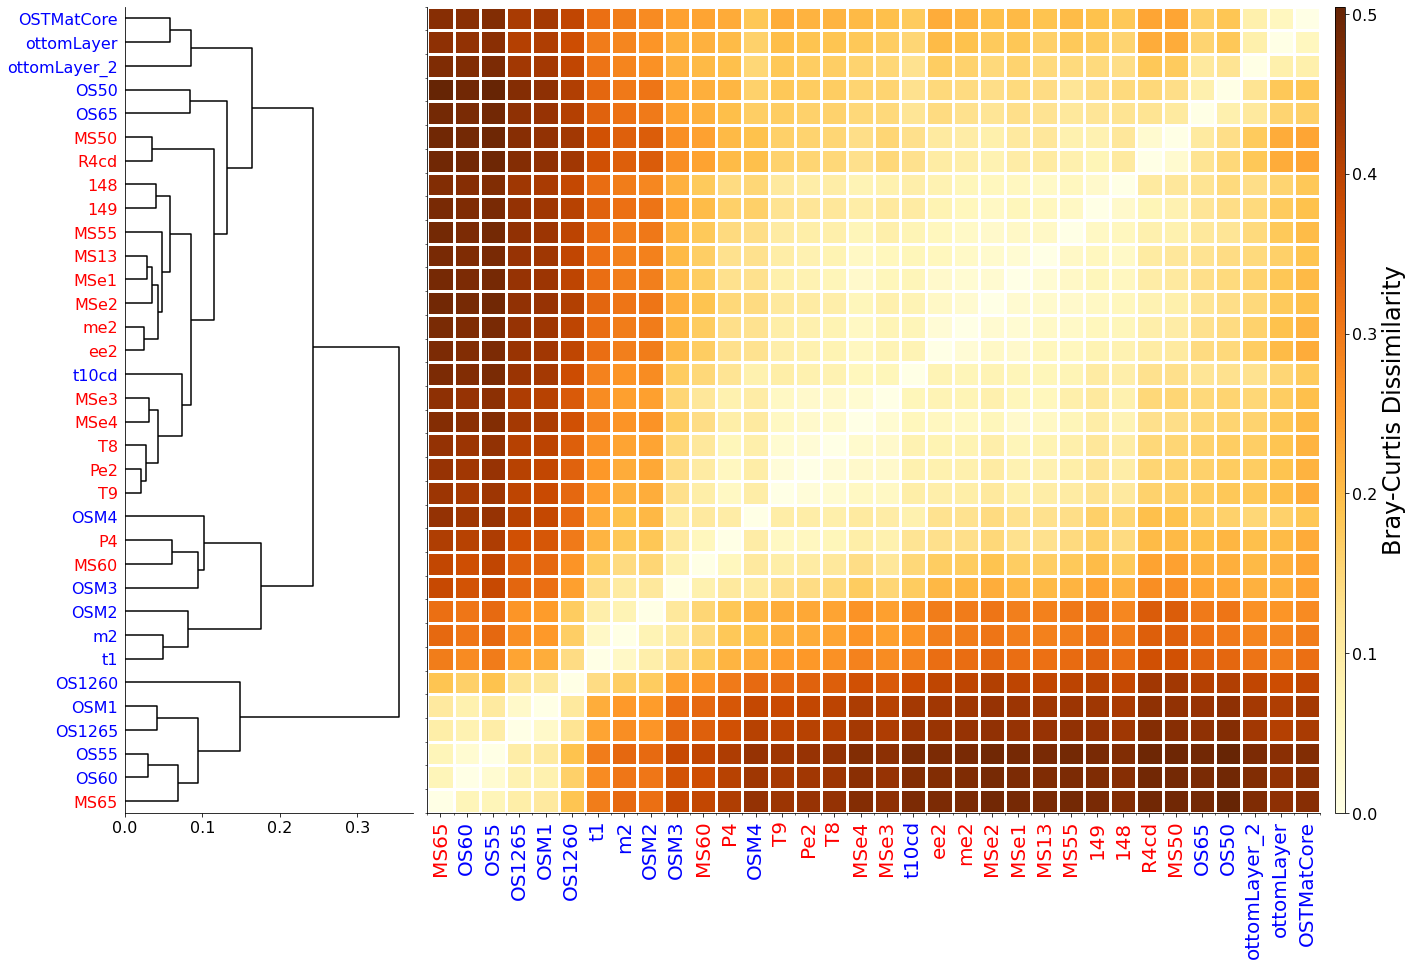

In [25]:
Dist_Mat = Summary['Synechococcus']['Respresentative_Abundances.Summary.pkl']['DistMat']
Feature_Mat = Summary['Synechococcus']['Respresentative_Abundances.Summary.pkl']['FeatMat']
ticks = np.array(Summary['Synechococcus']['Respresentative_Abundances.Summary.pkl']['Index'])

fig = plt.figure(figsize=(20,16))
axdendro = fig.add_axes([0.1,0.25,0.2,0.7])
axmatrix = fig.add_axes([0.31,0.25,0.62,0.7])
axcolor = fig.add_axes([0.94,0.25,0.0075,0.7])

Y = sch.linkage(squareform(Dist_Mat), method='weighted', optimal_ordering=True)
tree_index = sch.dendrogram(Y, color_threshold = 0, orientation='right', ax = axdendro, above_threshold_color='black')['leaves']
Dist_Mat = np.round(Dist_Mat[tree_index,:][:,tree_index], 5)

im = axmatrix.imshow(Dist_Mat, cmap  = "YlOrBr", aspect='auto', origin='lower', alpha = 1.0)
x_ticklabels = []
for t in ticks[tree_index]:
    t = t.replace("Hotspr20Sample","").replace("Hotspr2Sample","").replace("HotsprSample","")\
         .replace("HotsprSampl","").replace("HotsprSamp","").replace("Hotspr","")
    x_ticklabels.append(t)
axdendro.set_yticklabels(x_ticklabels, size = 16)
a = [axdendro.get_yticklabels()[i].set_color(mscolor) if (sample_spring[ticks[tree_index][i]] == 'Mushroom' ) 
     else axdendro.get_yticklabels()[i].set_color(oscolor) for i in range(len(axdendro.get_yticklabels()))]

axmatrix.set_xticks(range(0, len(ticks)))
axmatrix.set_xticklabels(x_ticklabels, rotation = 90, size = 20)
a = [axmatrix.get_xticklabels()[i].set_color(mscolor)  if (sample_spring[ticks[tree_index][i]] == 'Mushroom' ) 
     else axmatrix.get_xticklabels()[i].set_color(oscolor) for i in range(len(axmatrix.get_xticklabels()))]

axmatrix.set_xticks(np.arange(-.5, 34, 1), minor=True)
axmatrix.set_yticks(np.arange(-.5, 34, 1), minor=True)
axmatrix.grid(which='minor', color='white', linestyle='-', linewidth=3)
axmatrix.set_yticks([])
fig.colorbar(im, cax=axcolor)
axcolor.set_ylabel(r'Bray-Curtis Dissimilarity', size = 24)


Synechococcus [ 7. 17.] 	 [0.0109 0.0002]
Chloroflexus_MS_G [17.  5.] 	 [0.0002 0.0357]
Chloracidobacterium_thermophilum_B [0. 0.] 	 [0.6169 0.7263]
Roseiflexus [15.  4.] 	 [0.0005 0.0426]
Aerophilum [0. 2.] 	 [0.6495 0.1435]


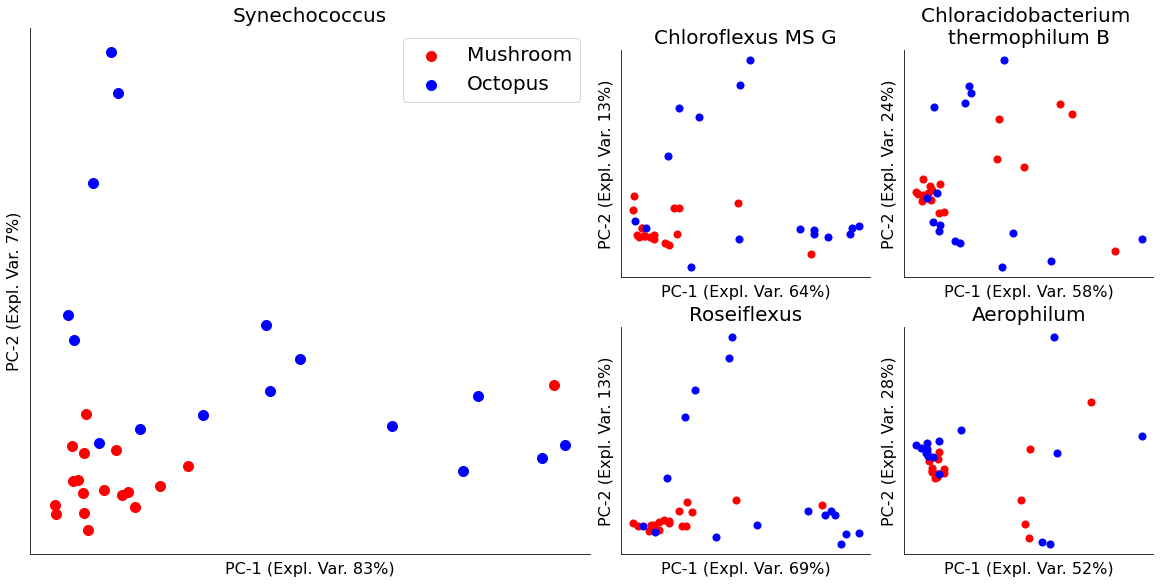

In [22]:
plt.rcParams.update(rcParams)

fig = plt.figure(constrained_layout = True,figsize = (16,8))
gs0 = fig.add_gridspec(1, 2)
ax = [fig.add_subplot(gs0[0])]
gs1 = gs0[1].subgridspec(2, 2)
for i in range(4): ax.append(fig.add_subplot(gs1[i]))

i = 0
titles = ["Synechococcus","Chloroflexus MS G", "Chloracidobacterium \nthermophilum B","Roseiflexus","Aerophilum"]
for g in genomes[2:]:
    var = Summary[g]['Respresentative_Abundances.Summary.pkl']['Expl_Var']
    df = Summary[g]['Respresentative_Abundances.Summary.pkl']['PC_Transformed']
    df = df.join(df_Metadata[['SampleID','Spring_Name']].set_index('SampleID'))
    df = df.reset_index().set_index('Spring_Name')
    if g == 'Synechococcus': 
        df.loc['Mushroom'].plot.scatter('PC-1','PC-2', color = mscolor, ax = ax[i], s = 100, label = 'Mushroom')
        df.loc['Octopus'].plot.scatter('PC-1','PC-2', color = oscolor, ax = ax[i], s = 100, label = 'Octopus')
    df.loc['Mushroom'].plot.scatter('PC-1','PC-2', color = mscolor, ax = ax[i], s = 50)
    df.loc['Octopus'].plot.scatter('PC-1','PC-2', color = oscolor, ax = ax[i], s = 50)
   
    ax[i].set_xlabel('PC-1 (Expl. Var. '+str(round(var[0]*100))+'%)')
    ax[i].set_ylabel('PC-2 (Expl. Var. '+str(round(var[1]*100))+'%)')
    ax[i].set_title(titles[i], size = 20)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    i += 1
    
    f, p = f_oneway(df.loc['Octopus'][['PC-1','PC-2']], df.loc['Mushroom'][['PC-1','PC-2']], axis = 0)
    print(g, np.round(f), "\t", np.round(p, 4))
  